In [20]:
import numpy as np
from chembl_webresource_client.new_client import new_client
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, rdMolDescriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [21]:
def target_retrieval(search):
    target = new_client.target
    target_query = target.search(search)
    targets = pd.DataFrame.from_dict(target_query)

    return targets

def target_info_retrieval(search):
    target = search['target_chembl_id'].iloc[0]
    activity = new_client.activity
    res = activity.filter(target_chembl_id=target, standard_type="IC50")
    df_1 = pd.DataFrame.from_dict(res)

    return df_1, target

def build_qsar_model(data):
    # Step 2: Clean the data
    df = pd.DataFrame(data)

    if 'value' not in df.columns:
        print('No data available for the given target and assay type.')
        return None

    # Step 3: Calculate pIC50
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['pIC50'] = -np.log10(df['value'] * 1e-9)

    # Step 4: Calculate molecular fingerprints
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['canonical_smiles']]
    fingerprints = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2) for mol in mols]
    fingerprint_array = np.array(fingerprints)
    df_fingerprints = pd.DataFrame(fingerprint_array, columns=[f'Bit_{i}' for i in range(fingerprint_array.shape[1])])

    # Step 5: Construct a QSAR model
    X = df_fingerprints
    y = df['pIC50']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_test, y_test, df_fingerprints.columns

def evaluate_molecule(mol_smiles, model):
    if model is None:
        print('Model not available. Please build the QSAR model first.')
        return None

    mol = Chem.MolFromSmiles(mol_smiles)
    fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)
    X = pd.DataFrame([list(fingerprint)], columns=[f'Bit_{i}' for i in range(fingerprint.GetNumBits())])
    pIC50 = model.predict(X)
    return pIC50[0]

def plot_predicted_vs_real(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Real pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title('Predicted vs. Real pIC50')
    plt.show()

def identify_pharmacophores(feature_importance, fingerprint_columns, threshold=0.01):
    pharmacophores = []
    for i, importance in enumerate(feature_importance):
        if importance > threshold:
            pharmacophores.append(fingerprint_columns[i])
    return pharmacophores

def draw_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        Chem.SanitizeMol(mol)
        return Chem.Draw.MolToImage(mol)
    else:
        return None

In [22]:
# Example usage
search_term = "CHEMBL3813586"
df_targets = target_retrieval(search_term)
df_activity, target_id = target_info_retrieval(df_targets)
model, X_test, y_test, fingerprint_columns = build_qsar_model(df_activity)

In [23]:
# Example molecule evaluation
test_mol_smiles = 'CC(=O)NC1=CC=CC=C1'
pIC50 = evaluate_molecule(test_mol_smiles, model)
if pIC50 is not None:
    print(f'Predicted pIC50: {pIC50}')

Predicted pIC50: 5.61367963970021


In [24]:
# Print target information and activity data
print("Target Information:")
print(df_targets)
print("\nActivity Data:")
print(df_activity)

Target Information:
  cross_references                               organism  \
0               []  Staphylococcus aureus (strain Newman)   

                    pref_name  score  species_group_flag target_chembl_id  \
0  Dehydrosqualene desaturase   17.0               False    CHEMBL3813586   

                                   target_components     target_type  tax_id  
0  [{'accession': 'O07855', 'component_descriptio...  SINGLE PROTEIN  426430  

Activity Data:
    action_type activity_comment  activity_id activity_properties  \
0          None             None     16612471                  []   
1          None             None     16612472                  []   
2          None             None     16612473                  []   
3          None             None     16612474                  []   
4          None             None     16612475                  []   
..          ...              ...          ...                 ...   
293        None             None     18705303

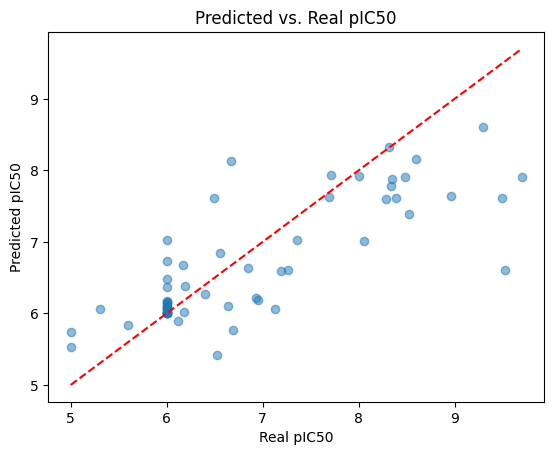

In [25]:
# Generate plots
y_pred = model.predict(X_test)
plot_predicted_vs_real(y_test, y_pred)